## Data Extraction and Return Computation

This notebook retrieves historical SPY price data from Yahoo Finance,
computes daily log returns, and provides initial statistical and visual
analysis to support subsequent Monte Carlo simulations.


In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

plt.style.use("seaborn-v0_8") # C'est juste pour avoir des graphiques plus beaux avec matplotlib


In [3]:
ticker = "SPY"
data = yf.download(ticker,start="2024-01-01",end="2026-01-01")
data.head()

C:\Users\marve\AppData\Local\Temp\ipykernel_32684\1809575469.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker,start="2024-01-01",end="2026-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2024-01-02,461.247437,462.242848,459.139542,460.769267,123623700
2024-01-03,457.480591,459.822686,456.875553,459.081011,103585900
2024-01-04,456.007050,459.598264,455.782588,457.002432,84232200
2024-01-05,456.631561,459.090756,455.177487,456.211912,86118900
2024-01-08,463.150421,463.296796,457.002389,457.129257,74879100


In [4]:
prices = data["Close"].dropna() # Le Close est déjà ajusté en prenant compte des dividendes et splits
prices.name = "SPY"
prices.tail()

Ticker,SPY
Date,
2025-12-24,690.380005
2025-12-26,690.309998
2025-12-29,687.849976
2025-12-30,687.010010
2025-12-31,681.919983


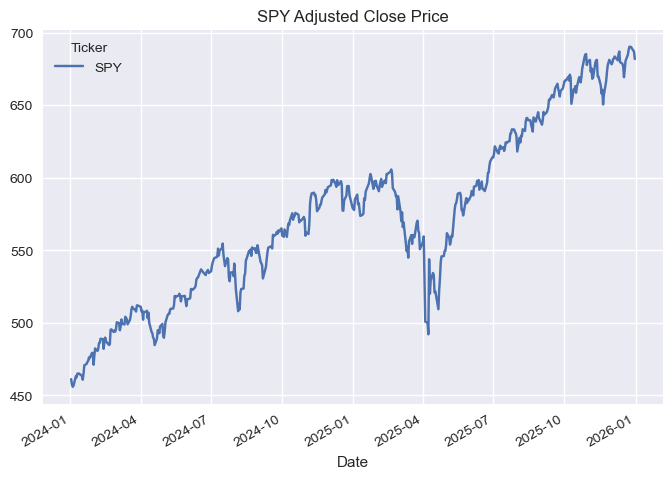

In [5]:
# Visualisation de l'évolution du prix sur 2ans
prices.plot(title="SPY Adjusted Close Price")
plt.show()


In [6]:
returns = np.log(prices / prices.shift(1)).dropna() # prices.shift(1) permet d'obtenir le prix de la veille
# On utilise le logarithme car on pourra utiliser la somme des variations relatives
returns.describe()

Ticker,SPY
count,501.000000
mean,0.000780
std,0.010261
min,-0.060327
25%,-0.003111
50%,0.001103
75%,0.005750
max,0.099863


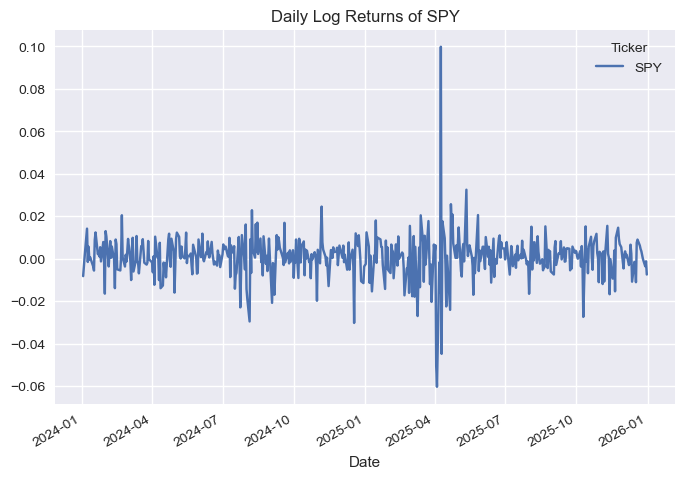

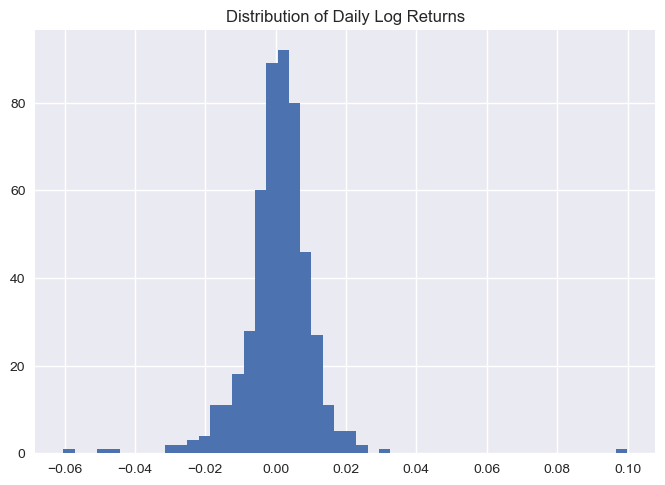

In [7]:
returns.plot(title="Daily Log Returns of SPY")
plt.show()

returns.hist(bins=50)
plt.title("Distribution of Daily Log Returns")
plt.show()

In [8]:
# Sauvegarde des prix
prices.to_csv("C:/Users/marve/OneDrive/Documents/Projets_Finance/MonteCarlo-SPY/data/spy_prices.csv")

# Sauvegarde des rendements journaliers
returns.to_csv("C:/Users/marve/OneDrive/Documents/Projets_Finance/MonteCarlo-SPY/data/spy_returns.csv")


## Daily Log Returns & Basic Statistics

This section computes the daily log returns of SPY from the extracted historical
price data, calculates key statistical metrics such as mean, daily and annualized
volatility, and visualizes the data through histograms and combined price vs returns
plots. These analyses help understand the short-term behavior of the asset and
prepare for subsequent risk simulations.


In [9]:
# returns contient les rendements log journaliers

# Moyenne et volatilité journalière
mean_daily = returns.mean()[0]  
vol_daily = returns.std()[0] # la volatilité correspond à l’écart-type des log-returns journaliers 

# Volatilité annualisée
vol_annual = vol_daily * np.sqrt(252)  # 252 jours de trading

print("Moyenne journalière:", mean_daily)
print("Volatilité journalière:", vol_daily)
print("Volatilité annualisée:", vol_annual)


Moyenne journalière: 0.0007803945831983243
Volatilité journalière: 0.010261154275517319
Volatilité annualisée: 0.16289077426491586


C:\Users\marve\AppData\Local\Temp\ipykernel_32684\982634515.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_daily = returns.mean()[0]
C:\Users\marve\AppData\Local\Temp\ipykernel_32684\982634515.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol_daily = returns.std()[0] # la volatilité correspond à l’écart-type des log-returns journaliers


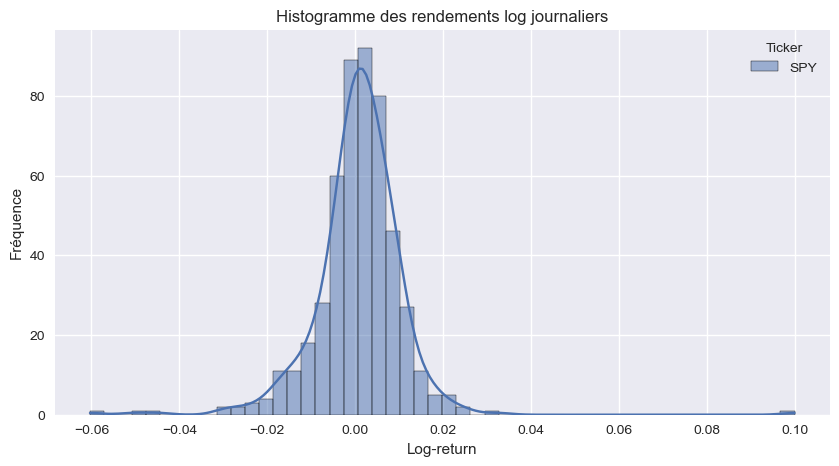

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(returns, bins=50, kde=True)
plt.title("Histogramme des rendements log journaliers")
plt.xlabel("Log-return")
plt.ylabel("Fréquence")
plt.show()


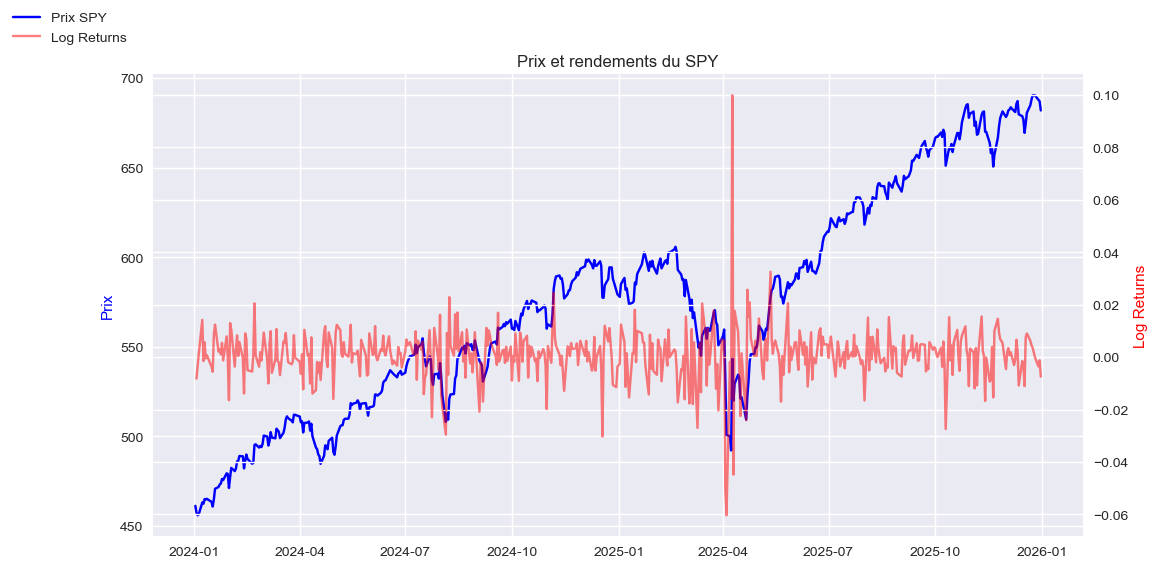

In [11]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Prix en bleu
ax1.plot(prices, color='blue', label='Prix SPY')
ax1.set_ylabel("Prix", color='blue')

# Rendements sur axe secondaire
ax2 = ax1.twinx()
ax2.plot(returns, color='red', alpha=0.5, label='Log Returns')
ax2.set_ylabel("Log Returns", color='red')

plt.title("Prix et rendements du SPY")
fig.legend(loc="upper left")
plt.show()


## Rolling Volatility Analysis

This section calculates the rolling volatility of SPY using two different windows:
short-term (20 days) and long-term (60 days). The comparison highlights the
instability of volatility over time and the limits of purely historical
estimations in risk assessment.


In [12]:
# Volatilité glissante
rolling_window_short = 20
rolling_window_long = 60

vol_short = returns.rolling(window=rolling_window_short).std()
vol_long = returns.rolling(window=rolling_window_long).std()
# La volatilité rolling montre comment le risque évolue dans le temps, contrairement à la volatilité historique calculée sur toute la période.

# Annualisation
vol_short_annual = vol_short * np.sqrt(252)
vol_long_annual = vol_long * np.sqrt(252)




In [13]:
# Si on ne veut pas utiliser rolling on peut faire une boucle

window = 20
vol_manual = []

for i in range(window, len(returns)+1):
    r_window = returns.iloc[i-window:i]  # les 20 derniers rendements
    vol_manual.append(r_window.std())

vol_manual = pd.Series(vol_manual, index=returns.index[window-1:])

vol_manual_annual = vol_manual * np.sqrt(252)




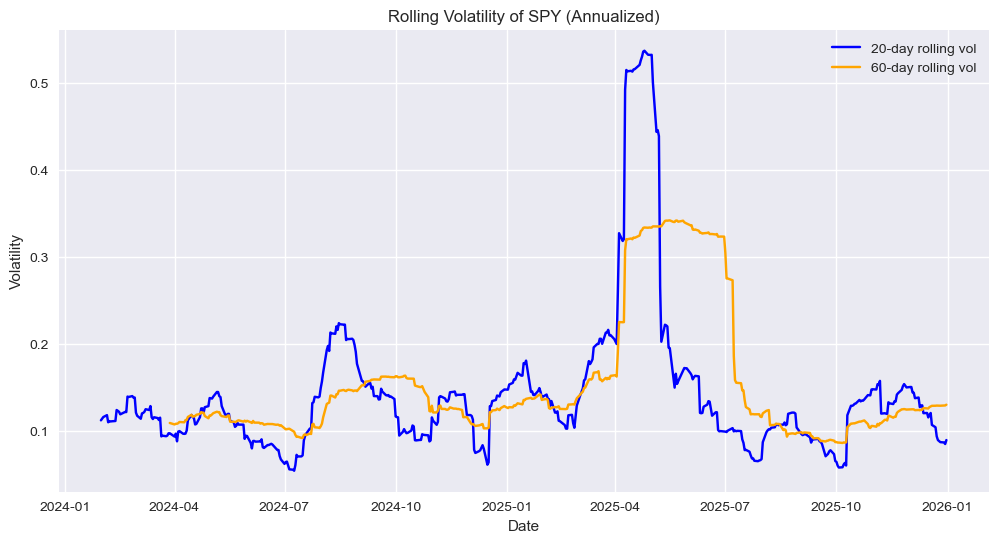

In [14]:
plt.figure(figsize=(12,6))
plt.plot(vol_short_annual, label=f"{rolling_window_short}-day rolling vol", color='blue')
plt.plot(vol_long_annual, label=f"{rolling_window_long}-day rolling vol", color='orange')
plt.title("Rolling Volatility of SPY (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()


### Market Intuition

- The volatility is clearly **not constant over time**: short-term spikes occur frequently.
- Historical estimates (based on past returns) have **limitations**:
    - They may **underestimate risk** during sudden market shocks.
    - They assume that the **future behavior is similar to the past**, which is often not true.
- This insight highlights that **models assuming constant volatility are limited**, and dynamic risk measures may be more appropriate.
